# Chapter 4 - Mudtrack cell tracking

## Here I'm going to introduce the Mudtrack method. In Mudtrack, we use the probability density of the enitre movie to track cells.

## The central dogma states that CPCs should migrate up the X-axis towards the lateral plate mesoderm. The X-axis is therefore used as a pseudotime to generate the trajectory.

In [1]:
import movie_reader, laplacian_fitler, watershed, centroid_detection, kalman
import numpy as np
from scipy.stats import kde
import matplotlib.pyplot as plt
import cv2

## First we detect the cells using the method described in Chapter 3

In [3]:
movie = movie_reader.MoviePlayer('outz/out_12.avi')
frames, frame_width, frame_height = movie.read_movie()


def run_detection(img_frame):

    new_frame = laplacian_fitler.LaplacianSegmenter(img_frame, 62, 0).apply_filter()
    new_frame = watershed.WatershedTransform(new_frame).run_watershed()
    centroids = centroid_detection.CentroidDetector(new_frame).find_contours()

    return centroids, new_frame


detect = [run_detection(I) for n, I in enumerate(frames)]
cents = [i[0] for i in detect]
cents = [[j for j in i if [0,0] not in j] for i in cents]
fra = [i[1] for i in detect]



## We use KDE to get a probability density estimate of the cell centroids in each frame, then add each frame KDE together to get a combined density estimate for the whole movie.

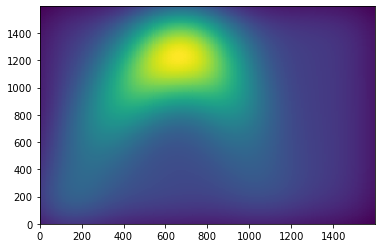

In [5]:
def get_grid(cents):
    all_cents = [i for j in cents for i in j]

    max_x = np.max([i[0] for i in all_cents])
    max_y = np.max([i[1] for i in all_cents])
    xi, yi = np.mgrid[0:max_x:250 * 1j, 0:max_y:250 * 1j]
    return xi, yi


ori_z = None


xi, yi = get_grid(cents)

for n, i in enumerate(cents):
    ki = kde.gaussian_kde([[j[0] for j in cents[n]],[1600-j[1] for j in cents[n]]])
    zi = np.array(ki(np.vstack([xi.flatten(), yi.flatten()])))
    
    if ori_z is None:
        ori_z = zi
    else:
        ori_z = ori_z + zi
    
ori_z = ori_z.reshape(xi.shape)
plt.pcolormesh(xi, yi, ori_z)
    

    
    

## For each X-position, I found the peak density along the Y-axis. I used this to generate the initial trajectory.

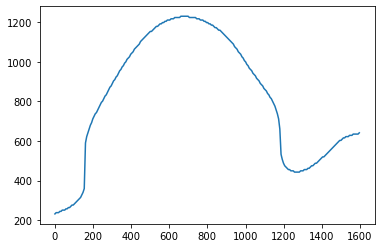

In [24]:
max_y = []
for i in range(0, ori_z.shape[1]):
    max_pos = np.argmax(ori_z[i])
    max_y.append(max_pos)

y_pos = xi[max_y, 0]
x_pos = xi[:,0]

plt.plot(x_pos, y_pos)

## I then applied a double Kalman filter to smoothen the trajectory

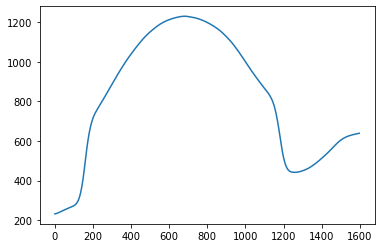

In [25]:
kf,_ = kalman.run_kf(x_pos, y_pos, 20)

plt.plot(kf[:,0], kf[:,2])